In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random 

from analysis import load_events, filter_events

In [2]:
events = load_events("../../data/2024-11-27_19-07-37-meated/logs_2024-11-28_23-45-57_637292.txt")

Start time: 1732861194.509901


In [3]:
for event in events:
    if event.name == "loaded_model":
        print(event.params)

{'model_name': '001000035'}
{'model_name': '001200035'}
{'model_name': '001350051'}
{'model_name': '001300003'}
{'model_name': '000902125'}
{'model_name': '001204743'}
{'model_name': '001005949'}
{'model_name': '001250019'}
{'model_name': '001150051'}
{'model_name': '000900003'}
{'model_name': '001100003'}
{'model_name': '001099850'}
{'model_name': '001152252'}
{'model_name': '001298961'}
{'model_name': '001246401'}
{'model_name': '001350898'}


In [4]:
game_result_events = filter_events(events, "game_result")
game_results = [event.params for event in game_result_events]

# I didn't zfill the player names, so we need to do that now
# for sorting to work.
# for game_result in game_results:
#     for result_line in game_result:
#         result_line[0] = result_line[0][1:].zfill(6)

players = set()
for game_result in game_results:
    for player, _ in game_result:
        players.add(player)

players = sorted(list(players))

print(players)
print("Number of games:", len(game_results))

['doublehandedness_0900k', 'doublehandedness_1000k', 'doublehandedness_1100k', 'doublehandedness_1150k', 'doublehandedness_1200k', 'doublehandedness_1250k', 'doublehandedness_1300k', 'doublehandedness_1350k', 'literatist_0900k', 'literatist_1000k', 'literatist_1100k', 'literatist_1150k', 'literatist_1200k', 'literatist_1250k', 'literatist_1300k', 'literatist_1350k']
Number of games: 1535


In [5]:
# Do a naive calculation of average performance per game per player.
player_total_scores = {player: 0 for player in players}
player_total_games = {player: 0 for player in players}

for game_result in game_results:
    for player, result in game_result:
        player_total_scores[player] += result
        player_total_games[player] += 1

player_average_scores = {player: player_total_scores[player] / player_total_games[player] for player in players}
player_average_scores

{'doublehandedness_0900k': 0.21350210970464134,
 'doublehandedness_1000k': 0.2084347120843471,
 'doublehandedness_1100k': 0.27186147186147186,
 'doublehandedness_1150k': 0.2453137734311328,
 'doublehandedness_1200k': 0.28882575757575757,
 'doublehandedness_1250k': 0.22518159806295399,
 'doublehandedness_1300k': 0.28184281842818426,
 'doublehandedness_1350k': 0.28185654008438815,
 'literatist_0900k': 0.22270531400966187,
 'literatist_1000k': 0.2562388591800357,
 'literatist_1100k': 0.22664835164835165,
 'literatist_1150k': 0.2616580310880829,
 'literatist_1200k': 0.2641597028783659,
 'literatist_1250k': 0.28024369016536116,
 'literatist_1300k': 0.22719935431799837,
 'literatist_1350k': 0.25279931093884583}

To use the stuff below, first run enough iterations in the first cell that the elos lines roughly converge. Then, run the bottom cell to generate a plot of the final elos.

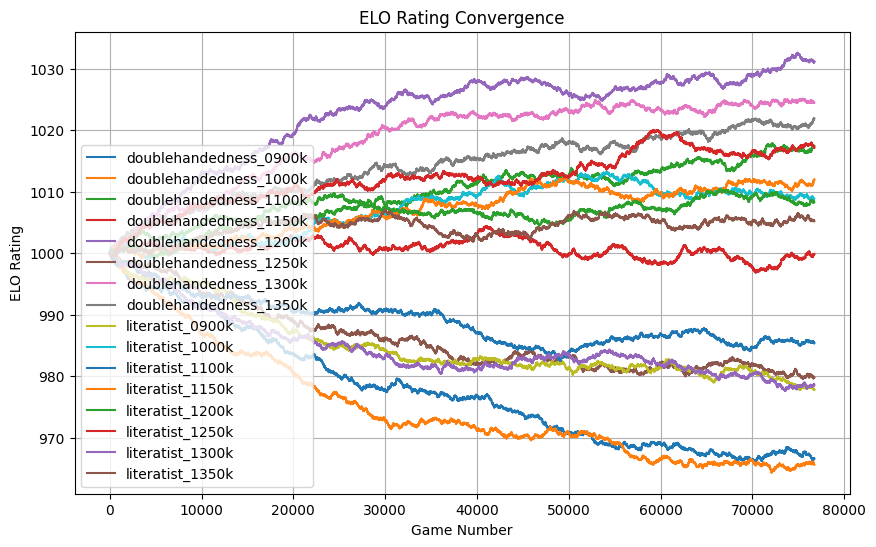

In [25]:
elos = [{player: 1000 for player in players}]

elo_K = 0.1
elo_base = 400.0

for _ in range(len(game_results) * 50):
    game_result = random.choice(game_results)

    latest_elo = elos[-1].copy()

    game_players = [player_name for player_name, _ in game_result]
    Q_player = [10 ** (latest_elo[player] / elo_base) for player in game_players]
    Q_total = sum(Q_player)
    E_player = [Q / Q_total for Q in Q_player]

    for i, (player, result) in enumerate(game_result):
        latest_elo[player] += elo_K * (result - E_player[i])

    elos.append(latest_elo)

# Extract player names from the first dictionary in elos
player_names = elos[0].keys()

# Prepare data for plotting
elo_history = {player: [] for player in player_names}

# Populate elo_history with ELO ratings over time
for elo_snapshot in elos:
    for player in player_names:
        elo_history[player].append(elo_snapshot[player])

# Plot ELO ratings for each player
plt.figure(figsize=(10, 6))
for player, history in elo_history.items():
    plt.plot(history, label=player)

plt.title("ELO Rating Convergence")
plt.xlabel("Game Number")
plt.ylabel("ELO Rating")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

final_elos = elos[-1]

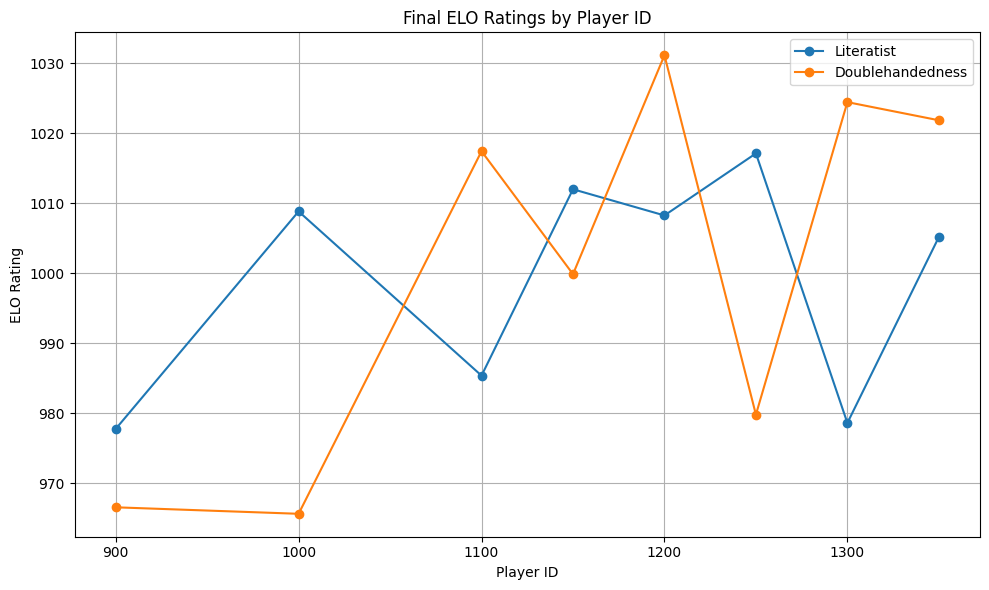

In [26]:
plt.figure(figsize=(10, 6))

elos_x = {}
elos_y = {}
for player in players:
    category, number_part = player.split("_")
    number = int(number_part[:-1])

    # The literatist 600k model is actually 642k
    if number == 600:
        number = 640

    elos_x[category] = elos_x.get(category, []) + [number]
    elos_y[category] = elos_y.get(category, []) + [final_elos[player]]

plt.plot(elos_x["literatist"], elos_y["literatist"], marker='o', label="Literatist")
plt.plot(elos_x["doublehandedness"], elos_y["doublehandedness"], marker='o', label="Doublehandedness")
plt.legend()

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.ylabel("ELO Rating")
plt.grid(True)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
# plt.xlim(left=0)  # Set x-axis to start at 0
plt.tight_layout()
plt.show()

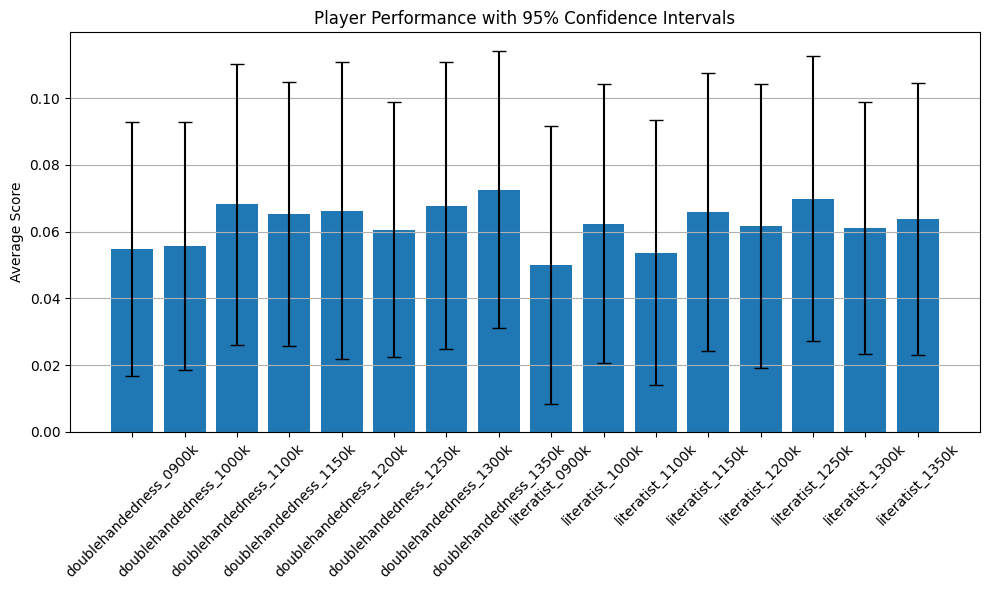

In [27]:
player_results = {}
total_results = {}
for game_result in game_results:
    for player, result in game_result:
        total_results[player] = total_results.get(player, 0) + result
        player_results[player] = player_results.get(player, []) + [result]

player_average = {}
sum_of_total_results = sum(total_results.values())
for player in total_results:
    player_average[player] = total_results[player] / sum_of_total_results

player_error_range = {}
for player in player_results:
    std = np.std(player_results[player]) / np.sqrt(len(player_results[player]))
    player_error_range[player] = 1.96 * std

plt.figure(figsize=(10, 6))

sorted_players = sorted(player_average.items(), key=lambda x: x[0])
players = [p[0] for p in sorted_players]
averages = [player_average[p] for p in players]
errors = [player_error_range[p] for p in players]

plt.bar(players, averages, yerr=errors, capsize=5)
plt.title("Player Performance with 95% Confidence Intervals")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()